In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

# Model evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Importing NLP libraries
from nltk.corpus import wordnet
import string
import nltk
import re
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("train_news.csv")
df.head()

,Unnamed: 0,id,headline,written_by,news,label
0,0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0
1,1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0
2,2,19113,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0
3,3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0
4,4,7596,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1


In [3]:
df.shape

(20800, 6)

In [4]:
df.nunique()

Unnamed: 0    20800
id            20800
headline      19803
written_by     4201
news          20386
label             2
dtype: int64

Unnamed:0 and id are unique, this can be removed

In [5]:
df.drop(columns=['id', 'Unnamed: 0'],inplace=True)
df.head()

,headline,written_by,news,label
0,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0
1,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0
2,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0
3,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0
4,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1


In [6]:
df.duplicated().sum()

109

In [7]:
df = df.drop_duplicates()
df.shape

(20691, 4)

In [8]:
print("Number of missing values in each column:")
print(df.isnull().sum())
print('\nPercentage of missing values in each column:')
print(round(100*df.isnull().sum()/len(df.index)),2)

Number of missing values in each column:
headline       518
written_by    1932
news            39
label            0
dtype: int64

Percentage of missing values in each column:
headline      3.0
written_by    9.0
news          0.0
label         0.0
dtype: float64 2


We can see written_by has manu null data, so we can remove this column

In [9]:
df.drop(columns=['written_by'],inplace=True)
df.head()

,headline,news,label
0,Ethics Questions Dogged Agriculture Nominee as...,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0
1,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,HOUSTON — Venezuela had a plan. It was a ta...,0
2,Cotton to House: ’Do Not Walk the Plank and Vo...,"Sunday on ABC’s “This Week,” while discussing ...",0
3,"Paul LePage, Besieged Maine Governor, Sends Co...","AUGUSTA, Me. — The beleaguered Republican g...",0
4,A Digital 9/11 If Trump Wins,Finian Cunningham has written extensively on...,1


In [10]:
df.dropna(axis=0, inplace=True)
df.shape

(20134, 3)

In [11]:
# Merging the headline and news
df['full_news'] = df[['headline', 'news']].apply(lambda x: ' '.join(x), axis = 1)
df.drop(columns=['headline', 'news'],inplace=True)
df.head()

,label,full_news
0,0,Ethics Questions Dogged Agriculture Nominee as...
1,0,U.S. Must Dig Deep to Stop Argentina’s Lionel ...
2,0,Cotton to House: ’Do Not Walk the Plank and Vo...
3,0,"Paul LePage, Besieged Maine Governor, Sends Co..."
4,1,A Digital 9/11 If Trump Wins Finian Cunningh...


In [13]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [14]:
def clean_text(text):
    text = text.lower()
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(b.isdigit() for b in word)]
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    text = [t for t in text if len(t) > 0]
    pos_tags = pos_tag(text)
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    text = [t for t in text if len(t) > 1]
    text = " ".join(text)
    return(text)

In [15]:
from tqdm import tqdm
for i in tqdm(range(1)):
    df["full_news_cleaned"] = df["full_news"].apply(lambda x: clean_text(x))

df.head()

100%|██████████| 1/1 [11:31<00:00, 691.16s/it]


,label,full_news,full_news_cleaned
0,0,Ethics Questions Dogged Agriculture Nominee as...,ethic question dog agriculture nominee georgia...
1,0,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,u.s must dig deep stop argentina’s lionel mess...
2,0,Cotton to House: ’Do Not Walk the Plank and Vo...,cotton house ’do walk plank vote bill cannot p...
3,0,"Paul LePage, Besieged Maine Governor, Sends Co...",paul lepage besiege maine governor send confli...
4,1,A Digital 9/11 If Trump Wins Finian Cunningh...,digital trump win finian cunningham write exte...


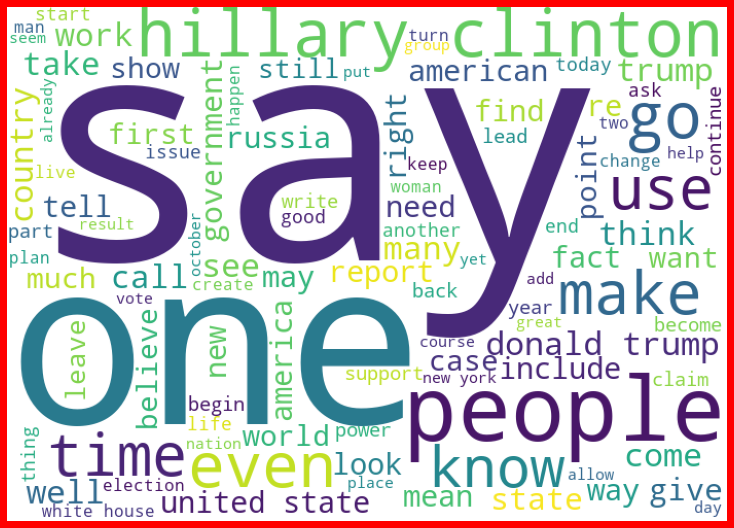

In [16]:
from wordcloud import WordCloud

fake = df["full_news_cleaned"][df['label']==1]

fake_cloud = WordCloud(width=700,height=500,background_color='white',max_words=100).generate(' '.join(fake))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(fake_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

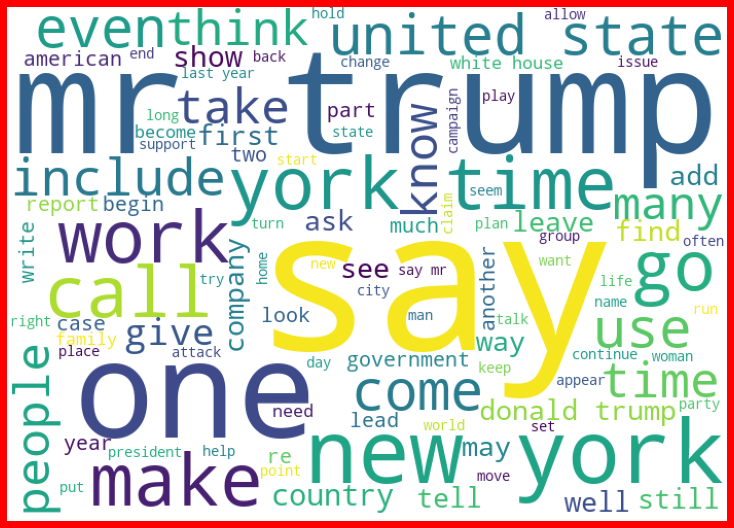

In [17]:
real = df["full_news_cleaned"][df['label']==0]

real_cloud = WordCloud(width=700,height=500,background_color='white',max_words=100).generate(' '.join(real))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(real_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

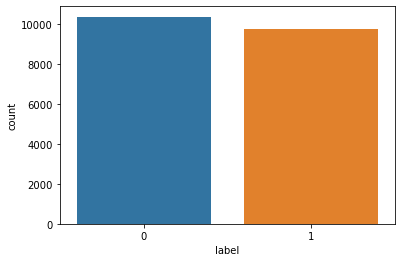

In [18]:
sns.countplot(df['label'])

Target data is balanced

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vec = TfidfVectorizer(ngram_range = (2,2))

X = tf_vec.fit_transform(df['full_news_cleaned'])
y = df['label']

In [20]:
# Split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=42)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16107, 3976042), (4027, 3976042), (16107,), (4027,))

We're going to try below machine learning models:

 1. Logistic Regression
 2. Random Forest Classifier
 3. XGBClassifier
 4. PassiveAggressiveClassifier

In [22]:
# Put models in a dictionary
models = {
          "Logistic Regression": LogisticRegression(), 
          "Random Forest": RandomForestClassifier(),
          "xgb": XGBClassifier(),
          "PassiveAggressiveClassifier": PassiveAggressiveClassifier()
          }

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [23]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

model_scores

{'Logistic Regression': 0.9456170846784206,
 'Random Forest': 0.9418922274646139,
 'xgb': 0.9528184752917804,
 'PassiveAggressiveClassifier': 0.9607648373479016}

In [24]:
lr = LogisticRegression()
xgb = XGBClassifier()
pac = PassiveAggressiveClassifier()

In [28]:
models = []
models.append(('LogisticRegression', lr))
models.append(('XGBoost', xgb))
models.append(('PasiveAggressiveClassifier', pac))


In [29]:
Model = []
score = []
cvs=[]
rocscore=[]
for name, model in models:
    print('*******************', name, '*******************\n') 
    Model.append(name)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    acc_score = accuracy_score(y_test, pred)
    print(f"Accuracy_Score  =  {acc_score*100:.2f}%")
    score.append(acc_score * 100)
    
    cross_val = cross_val_score(model, X, y, cv=10, scoring='accuracy').mean()
    print(f"Cross_Val_Score =  {cross_val*100:.2f}%")
    cvs.append(cross_val * 100)
     
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print(f"roc_auc_score   =  {roc_auc*100:.2f}%")
    rocscore.append(roc_auc * 100)
    
    print('\n Classification_report \n', classification_report(y_test, pred))
    print('\n')
    print('Confusion Matrix \n\n',confusion_matrix(y_test, pred))
    print('\n')  


******************* LogisticRegression *******************

Accuracy_Score  =  94.56%
Cross_Val_Score =  95.01%
roc_auc_score   =  94.59%

 Classification_report 
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      2098
           1       0.93      0.95      0.94      1929

    accuracy                           0.95      4027
   macro avg       0.95      0.95      0.95      4027
weighted avg       0.95      0.95      0.95      4027



Confusion Matrix 

 [[1969  129]
 [  90 1839]]


******************* XGBoost *******************

Accuracy_Score  =  95.28%
Cross_Val_Score =  95.34%
roc_auc_score   =  95.34%

 Classification_report 
               precision    recall  f1-score   support

           0       0.97      0.94      0.95      2098
           1       0.94      0.97      0.95      1929

    accuracy                           0.95      4027
   macro avg       0.95      0.95      0.95      4027
weighted avg       0.95      0.95

Text(0.5, 0, 'False Positive Rate')

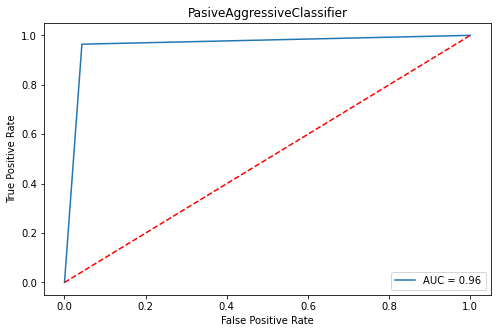

In [37]:
plt.figure(figsize=(8,5))
plt.title(name)
plt.plot(false_positive_rate, true_positive_rate, label='AUC = %0.2f'% roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [30]:
result = pd.DataFrame({'Model': Model, 'Accuracy_score': score ,'Cross_val_score':cvs,'Roc_auc_curve':rocscore})
result

,Model,Accuracy_score,Cross_val_score,Roc_auc_curve
0,LogisticRegression,94.561708,95.013445,94.592829
1,XGBoost,95.281848,95.336236,95.342425
2,PasiveAggressiveClassifier,96.051651,96.761739,96.066609


Here we can see that PasiveAggressiveClassifier performed better than other models with ROC_AUC score of 96%. This can select as final model.